In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58801 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:58804" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:58823, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:58829, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:58826, threads: 2>})

In [4]:
train_X = pd.read_pickle('DFs/train_test/train_X.pkl')
train_y = pd.read_pickle('DFs/train_test/train_y.pkl')
test_X = pd.read_pickle('DFs/train_test/test_X.pkl')
test_y = pd.read_pickle('DFs/train_test/test_y.pkl')

In [5]:
f = open(r'DFs/train_test/participants.pkl', 'rb')
participants = pickle.load(f)
f.close()

In [6]:
from model_prep import score_model

In [7]:
from model_prep import plot_predictions

# PCA
Reducing dimensionality to keep computation times practical

In [8]:
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)

# RandomForest 10 Estimators
We will start with 10 estimators and work from there once we have determined computation times

In [9]:
#create and fit model
rf10 = RandomForestRegressor(n_estimators=10, verbose=True)
with joblib.parallel_backend('dask'):
    rf10.fit(train_X_pca50, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.1s finished


In [10]:
#create logging dictionary
rf_scores = {'model':[],'par':[],'MAPE':[], 'MAE':[]}
for param in rf10.get_params():
    rf_scores[param]=[]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


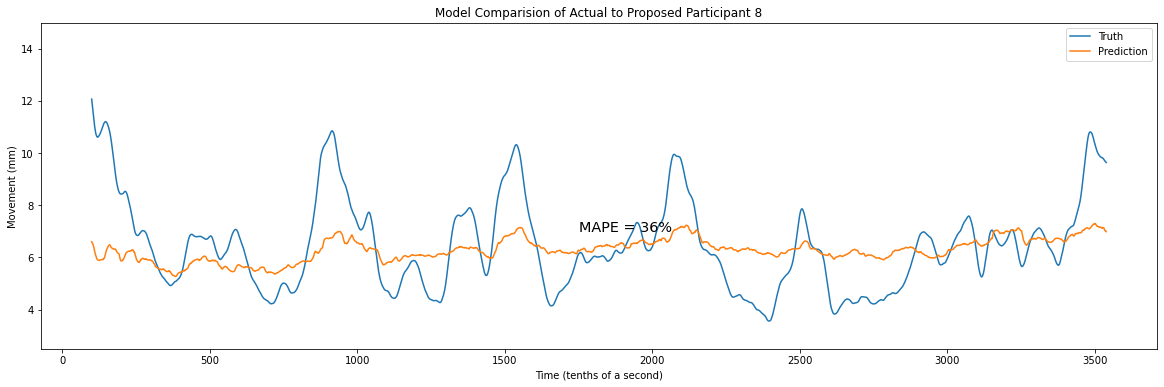

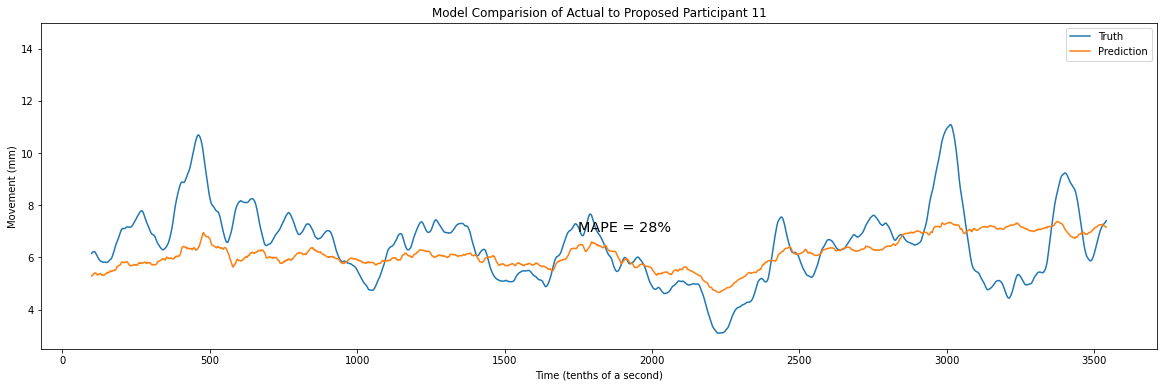

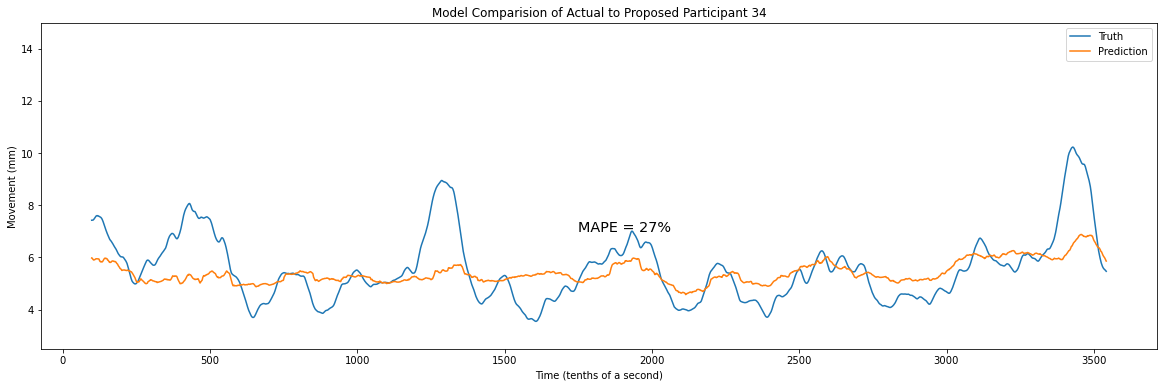

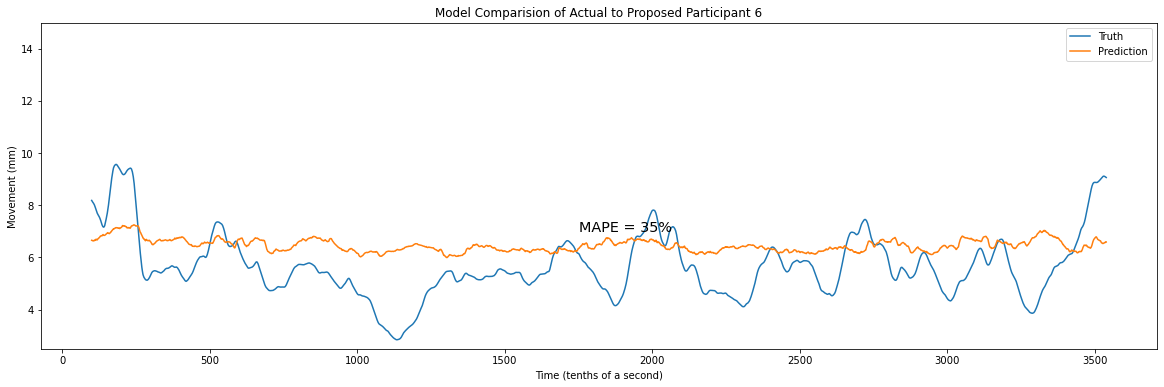

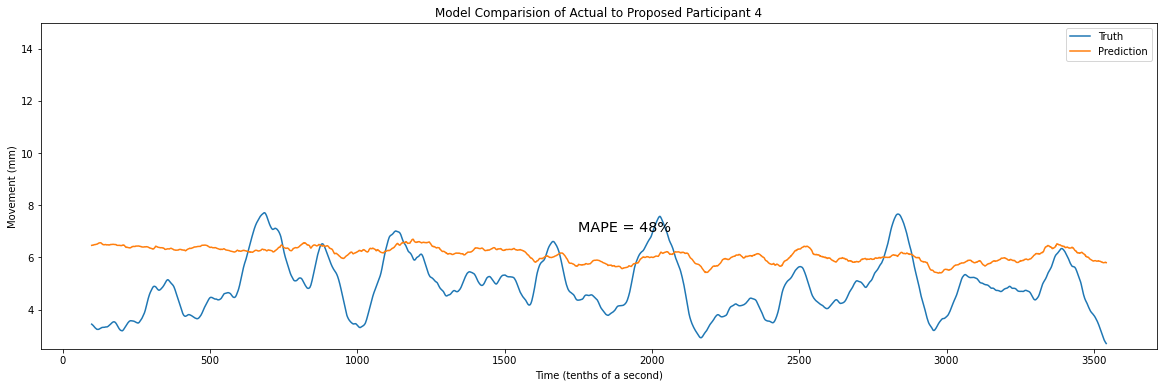

In [11]:
#Visualize predicted and actual data
results, rf_scores = score_model(rf10, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='RF10', log = rf_scores)
plot_predictions(results, participants)

RandomForest does a little worse on the metrics of MAE and MAPE, but seems a little more sensitve to the the amplitude of the data. It doesn't appear that it does better with predicting participants with more variance, but it is more sensitive to them. Lets try adding estimators to see if it performs better.

In [12]:
rf_scores.keys()

dict_keys(['model', 'par', 'MAPE', 'MAE', 'bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

# RandomForest 50 Estimators

In [13]:
#create and fit model
rf50 = RandomForestRegressor(n_estimators=50, verbose=True)
with joblib.parallel_backend('dask'):
    rf50.fit(train_X_pca50, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.4s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


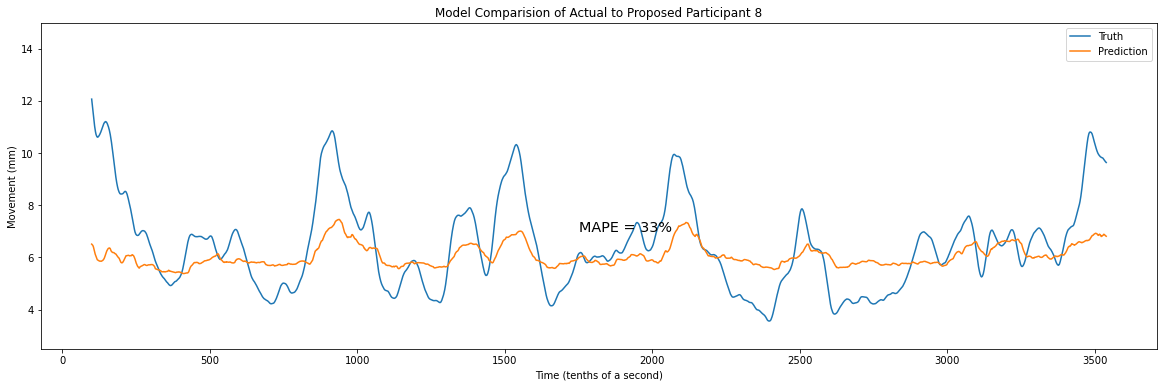

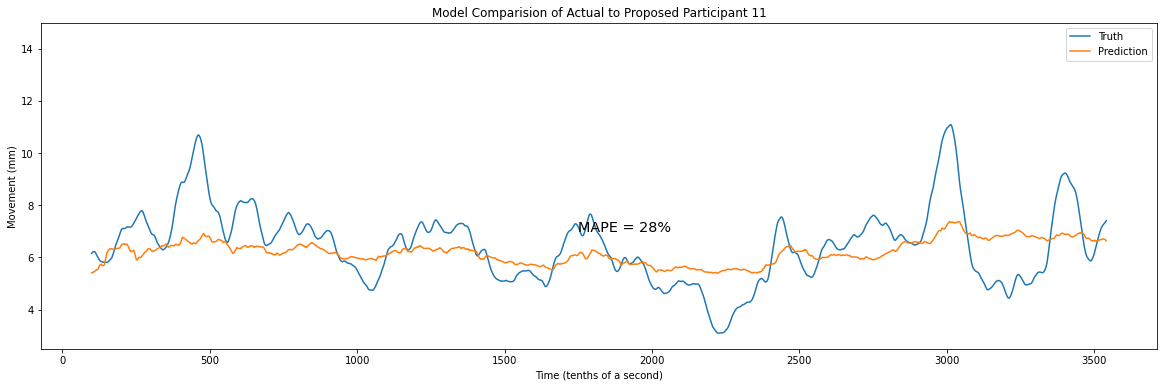

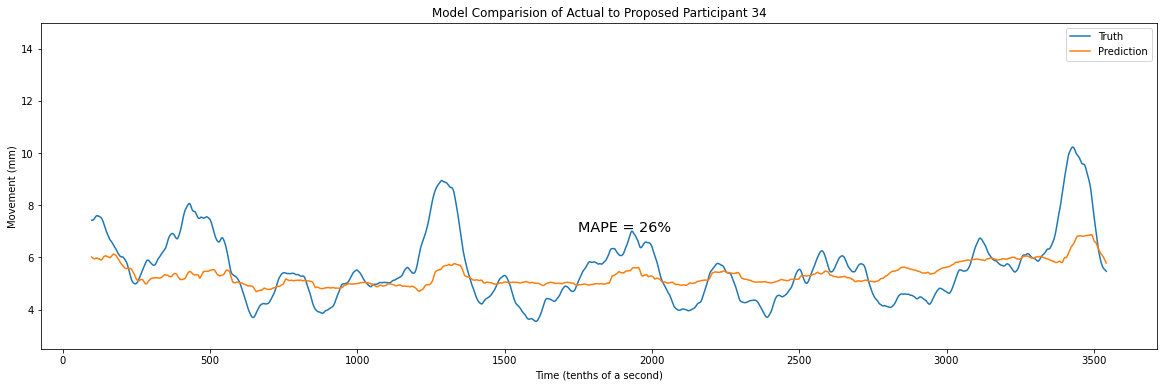

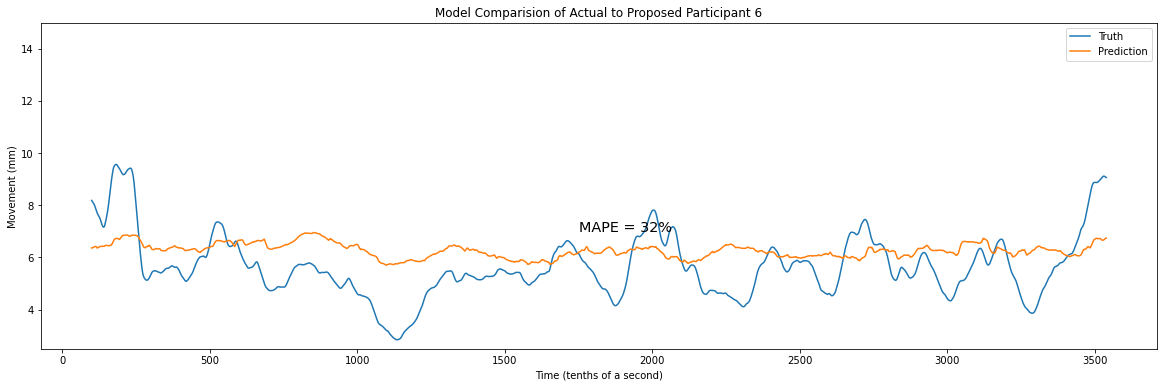

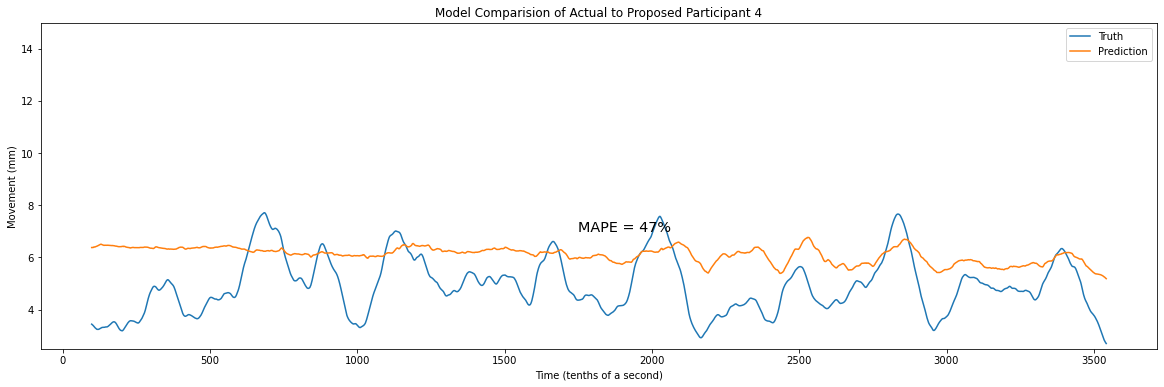

In [14]:
#visual predictions and truth data
results, rf_scores = score_model(rf50, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                     model_name='RF50', log = rf_scores)
plot_predictions(results, participants)

Some improvement though to varying degrees with different participants. It does seem to be a bit more smoothed out relative to the ten estimator model.

# RandomForest 250 Estimators

In [15]:
#create and fit model
rf250 = RandomForestRegressor(n_estimators=250, verbose=True)
with joblib.parallel_backend('dask'):
    rf250.fit(train_X_pca50, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.6min finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished


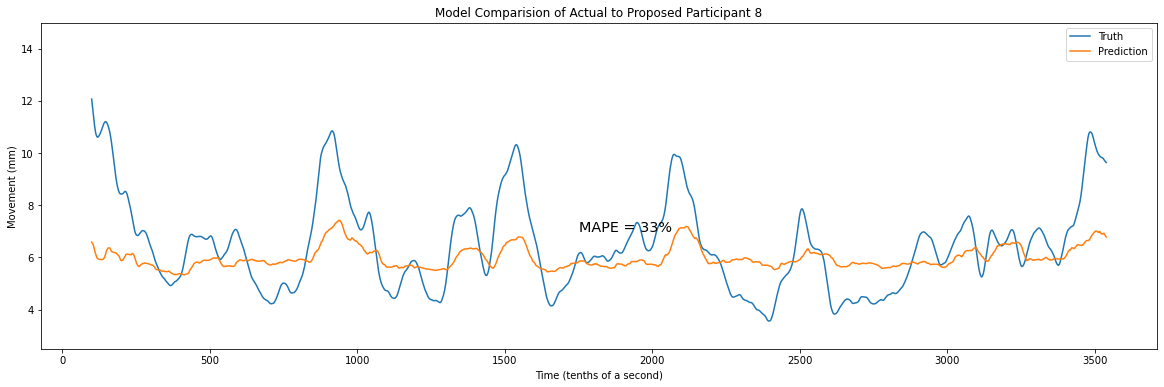

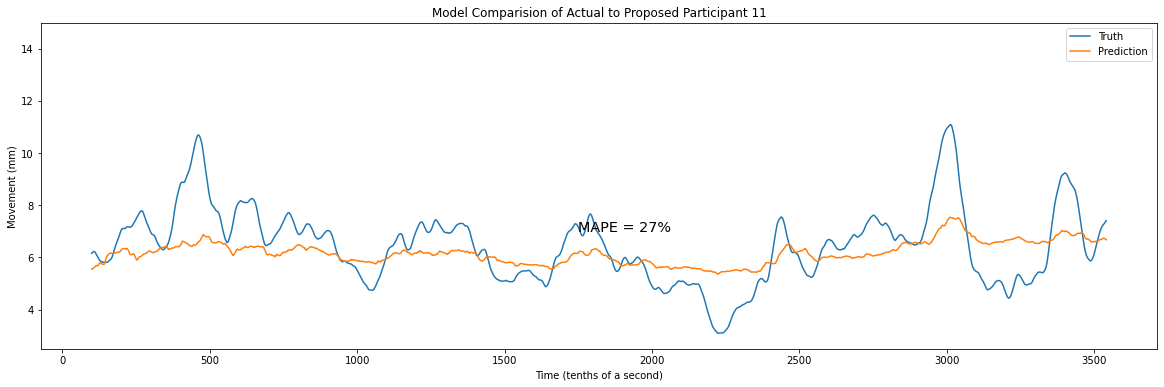

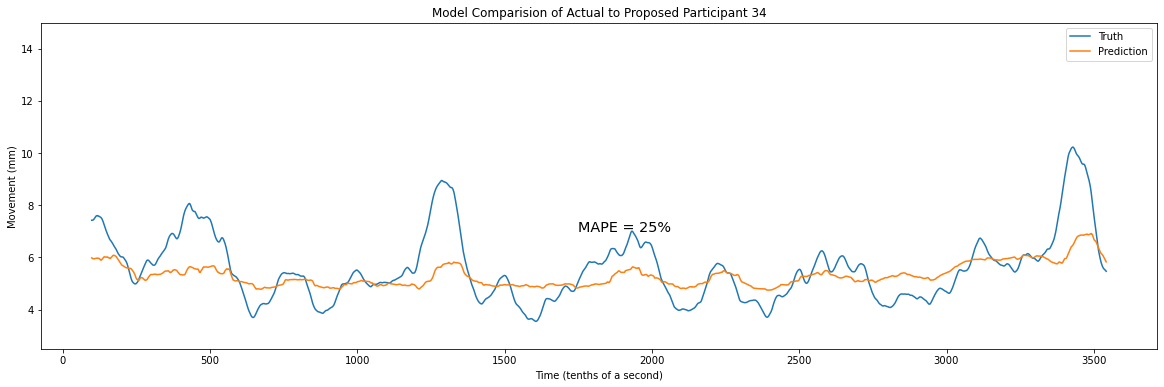

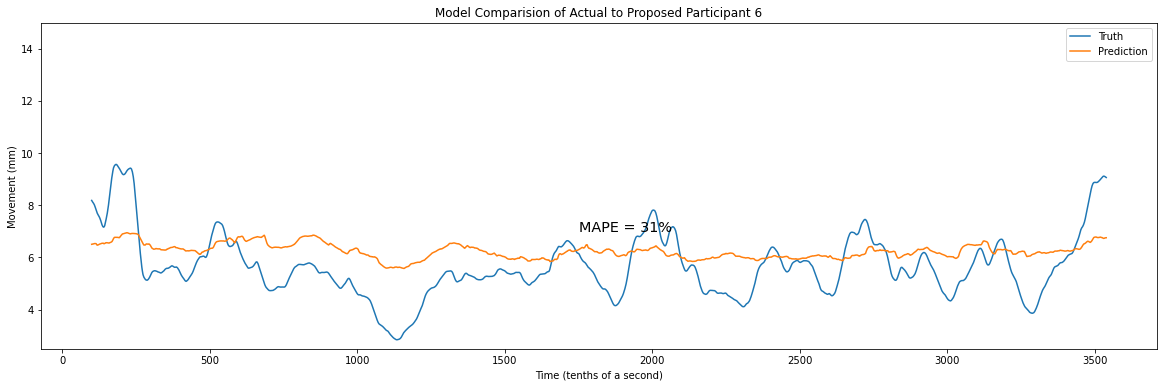

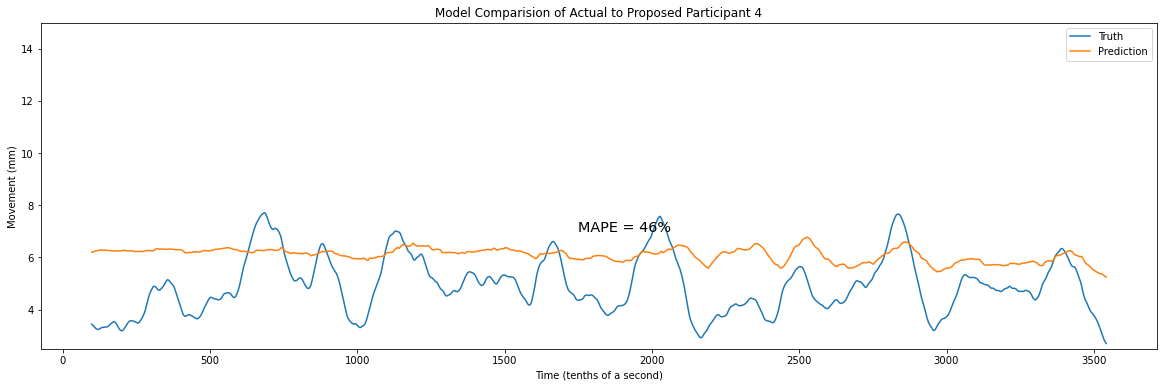

In [16]:
#visualize predictions and truths
results, rf_scores = score_model(rf250, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                     model_name='RF250', log = rf_scores)
plot_predictions(results, participants)

RandomForest appears to be doing worse than the linear ElasticNet model. It is possible with some further parameter tuning that the error could be reduced, but I'm not sure we could get to a smooth trend that follows the data as the linear model appears capable of.

In [17]:
#convert dictionary to dataframe
rf_df = pd.DataFrame(rf_scores)

In [18]:
#review metrics and parameters by model
rf_df.groupby(['par','model']).mean()

MAPE       MAE  bootstrap  ccp_alpha  min_impurity_decrease  \
par model                                                                    
4   RF10   0.482703  1.810018       True        0.0                    0.0   
    RF250  0.468878  1.751661       True        0.0                    0.0   
    RF50   0.471096  1.759581       True        0.0                    0.0   
6   RF10   0.356275  1.705638       True        0.0                    0.0   
    RF250  0.316360  1.542217       True        0.0                    0.0   
    RF50   0.324341  1.580983       True        0.0                    0.0   
8   RF10   0.361779  2.114950       True        0.0                    0.0   
    RF250  0.337840  2.067781       True        0.0                    0.0   
    RF50   0.335601  2.037626       True        0.0                    0.0   
11  RF10   0.287854  1.747453       True        0.0                    0.0   
    RF250  0.279651  1.676977       True        0.0                    0.0   
    RF50   0.283677  1.696513       True        0.0                    0.0   
34  RF10   0.271668  1.437698       True        0.0                    0.0   
    RF250  0.255148  1.372785       True        0.0                    0.0   
    RF50   0.265012  1.415400       True        0.0                    0.0   

           min_samples_leaf  min_samples_split  min_weight_fraction_leaf  \
par model                                                                  
4   RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   
6   RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   
8   RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   
11  RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   
34  RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   

           n_estimators  oob_score  verbose  warm_start  
par model                                                
4   RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False  
6   RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False  
8   RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False  
11  RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False  
34  RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False

In [19]:
#Metrics by model
rf_df.groupby(['model']).mean()

,par,MAPE,MAE,bootstrap,ccp_alpha,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,verbose,warm_start
model,,,,,,,,,,,,,
RF10,12.6,0.352056,1.763151,True,0.0,0.0,1.0,2.0,0.0,10.0,False,True,False
RF250,12.6,0.331575,1.682284,True,0.0,0.0,1.0,2.0,0.0,250.0,False,True,False
RF50,12.6,0.335945,1.698020,True,0.0,0.0,1.0,2.0,0.0,50.0,False,True,False


In [20]:
#output metrics for comparison
rf_df.to_pickle(r'DFs/scores/rf.pkl')